<a href="https://colab.research.google.com/github/YukeZou0605/When-Words-Move-Markets/blob/main/MAIS202_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import pandas as pd
from datetime import datetime

folder_path = "/content"

data = []

for file_name in os.listdir(folder_path):
  if file_name.endswith(".txt"):
    file_path = os.path.join(folder_path, file_name)

    with open(file_path, "r", encoding = "utf-8") as f:
      text = f.read()

    match = re.search(r'(\d{8})', file_name)
    date = None

    if match:
      date_str = match.group(1)
      date = datetime.strptime(date_str, "%Y%m%d")


    data.append({
        "filename": file_name,
        "date": date,
        "text": text
    })

df_transcripts = pd.DataFrame(data)

df_transcripts.head()


,filename,date,text
0,FOMCpresconf20221214.txt,2022-12-14,<NAME>CHAIR POWELL</NAME>. Good afternoon. Bef...
1,FOMCpresconf20241218.txt,2024-12-18,<NAME>CHAIR POWELL</NAME>. Good afternoon. My ...
2,FOMCpresconf20240918.txt,2024-09-18,<NAME>CHAIR POWELL</NAME>. Good afternoon. My ...
3,FOMCpresconf20230726.txt,2023-07-26,<NAME>CHAIR POWELL</NAME>. Good afternoon. My ...
4,FOMCpresconf20240131.txt,2024-01-31,<NAME>CHAIR POWELL</NAME>. Good afternoon. My ...


In [ ]:
# Downlaod S&P 500 Data (^GSPC in yfinance)

import yfinance as yf

start = (df_transcripts["date"].min() - pd.Timedelta(days = 7))
end = (df_transcripts["date"].max() + pd.Timedelta(days = 7))

start = start.strftime("%Y-%m-%d")
end = end.strftime("%Y-%m-%d")

sp500 = yf.download("^GSPC", start = start, end = end, progress = False)

# Next day return = (tmr's close - today's close) / today's close

sp500["Return"] = sp500["Close"].pct_change().shift(-1)

sp500 = sp500[["Return"]].copy()
sp500.head()


/tmp/ipython-input-357435558.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start = start, end = end, progress = False)


Price,Return
Ticker,
Date,
2020-09-09,-0.017585
2020-09-10,0.000533
2020-09-11,0.012742
2020-09-14,0.005219
2020-09-15,-0.004619


In [ ]:
# (1) extract prepared_text

def extract_powell_prepared(text: str) -> str:

    if not isinstance(text, str) or not text.strip():
        return ""

    start = re.search(r"<NAME>\s*CHAIR\s+POWELL\s*</NAME>", text, re.I)
    if not start:
        return ""  # if

    end = re.search(r"<NAME>\s*MICHELLE\s+SMITH\s*</NAME>", text, re.I)

    start_idx = start.end()
    end_idx = end.start() if end else len(text)

    section = text[start_idx:end_idx]
    section = re.sub(r"<NAME>.*?</NAME>", "", section, flags=re.I)  # get rid of labels
    section = re.sub(r"\s+", " ", section).strip()                  # get rid of blanks


    return section



df_transcripts["prepared_text"] = df_transcripts["text"].apply(extract_powell_prepared)

# drop the line if it is a blank
df_transcripts = df_transcripts[df_transcripts["prepared_text"].str.len() > 0].copy()



# (2) use FinBERT to compute for hawkish_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, torch.nn.functional as F
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL = "yiyanghkust/finbert-tone"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(DEVICE).eval()

def hawkish_score(text: str, max_tokens=512, stride=64) -> float:
    """
    hawkish_score = P(positive) - P(negative)
    cut the long text into short pieces；compute the weighted average of each logit based on their length，then do softmax。
    """
    if not text:
        return 0.0

    enc = tokenizer(text, return_tensors="pt", truncation=False)
    ids = enc["input_ids"][0]

    step = max_tokens - stride if max_tokens > stride else max_tokens
    chunks = [ids[i:i+max_tokens] for i in range(0, len(ids), step)]

    logits_list, lens = [], []
    for cids in chunks:
        attn = torch.ones_like(cids)
        with torch.no_grad():
            out = model(
                cids.unsqueeze(0).to(DEVICE),
                attention_mask=attn.unsqueeze(0).to(DEVICE)
            )
        logits_list.append(out.logits.squeeze(0).cpu())  # [3]
        lens.append(len(cids))

    L = torch.tensor(lens, dtype=torch.float32).unsqueeze(1)      # [n,1]
    avg_logits = (torch.stack(logits_list, 0) * L / L.sum()).sum(0)
    probs = F.softmax(avg_logits, dim=-1).numpy()                 # [pos, neu, neg]
    return float(probs[0] - probs[2])


tqdm.pandas(desc="FinBERT hawkish scoring")
df_transcripts["hawkish_score"] = df_transcripts["prepared_text"].progress_apply(hawkish_score)



#  (3) rearrange the data and have a check
df_transcripts["date"] = pd.to_datetime(df_transcripts["date"]).dt.date
df_transcripts = df_transcripts.sort_values("date").reset_index(drop=True)

# only check the title with key labels
df_transcripts[["filename", "date", "hawkish_score"]].head()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

FinBERT hawkish scoring:   0%|          | 0/39 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

FinBERT hawkish scoring: 100%|██████████| 39/39 [04:42<00:00,  7.23s/it]


,filename,date,hawkish_score
0,FOMCpresconf20200916.txt,2020-09-16,0.455728
1,FOMCpresconf20201105.txt,2020-11-05,0.660507
2,FOMCpresconf20201216.txt,2020-12-16,0.328350
3,FOMCpresconf20210127.txt,2021-01-27,-0.064276
4,FOMCpresconf20210317.txt,2021-03-17,0.318639


In [ ]:
# Merge the two data frames
# File name + date + text + next day S&P 500 return

df_transcripts["date"] = pd.to_datetime(df_transcripts["date"]).dt.normalize()
df_transcripts = df_transcripts.sort_values("date").reset_index(drop=True)

if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = ["_".join([str(x) for x in t if x]) for t in sp500.columns]

if "Return" not in sp500.columns:
    close_col = "Close" if "Close" in sp500.columns else "Price_Close"
    sp500["Return"] = sp500[close_col].pct_change().shift(-1)

mkt = (
    sp500.reset_index()
         .rename(columns={"Date": "date"})[["date", "Return"]]
         .assign(date=lambda d: pd.to_datetime(d["date"]).dt.normalize())
         .sort_values("date")
)


df = pd.merge_asof(
    df_transcripts.sort_values("date"),
    mkt,
    on="date",
    direction="forward",
    allow_exact_matches=True
)

print(df.shape)
print("Labeled rows:", df["Return"].notna().sum(), "out of", len(df))
display(df[["filename","date","Return"]].head(10))

# print(df.columns)

# df[["filename", "date", "hawkish_score", "Return"]].head()

df_final = df[["filename", "date", "hawkish_score", "Return"]].copy()
# df_final.head()


(39, 6)
Labeled rows: 39 out of 39


,filename,date,Return
0,FOMCpresconf20200916.txt,2020-09-16,-0.008412
1,FOMCpresconf20201105.txt,2020-11-05,-0.000288
2,FOMCpresconf20201216.txt,2020-12-16,0.005758
3,FOMCpresconf20210127.txt,2021-01-27,0.009761
4,FOMCpresconf20210317.txt,2021-03-17,-0.014761
5,FOMCpresconf20210428.txt,2021-04-28,0.006763
6,FOMCpresconf20210616.txt,2021-06-16,-0.000436
7,FOMCpresconf20210728.txt,2021-07-28,0.004206
8,FOMCpresconf20210922.txt,2021-09-22,0.012135
9,FOMCpresconf20211103.txt,2021-11-03,0.004182


,filename,date,hawkish_score,Return
0,FOMCpresconf20200916.txt,2020-09-16,0.455728,-0.008412
1,FOMCpresconf20201105.txt,2020-11-05,0.660507,-0.000288
2,FOMCpresconf20201216.txt,2020-12-16,0.328350,0.005758
3,FOMCpresconf20210127.txt,2021-01-27,-0.064276,0.009761
4,FOMCpresconf20210317.txt,2021-03-17,0.318639,-0.014761


In [ ]:
# Predictive Model

#df_final = df_final.dropna(subset = ["hawkish_score", "Return"])
#X = df_final[["hawkish_score"]].sort_values(by="hawkish_score").values
#y = df_final["Return"].values

#split_index = int(len(df_final) * 0.8)
#X_train, X_test = X[:split_index], X[split_index:]
#y_train, y_test = y[:split_index], y[split_index:]

#from sklearn.linear_model import LinearRegression

#linreg = LinearRegression()
#linreg.fit(X_train, y_train)

#preds = linreg.predict(X_test)

In [ ]:
# Predictive Model --> Linear Regression
# Pipeline


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Drop missing rows just in case
df_final = df_final.dropna(subset=["hawkish_score", "Return"])

# Features & target
X = df_final[["hawkish_score"]].values
y = df_final["Return"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, shuffle = False
)

# Build pipeline
linreg_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # handles any missing values
    ("model", LinearRegression())
])

# Train
linreg_pipeline.fit(X_train, y_train)

# Predict
y_pred = linreg_pipeline.predict(X_test)

# Performance Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression Performance:")
print(f"R-squared: {r2:.5f}")
print(f"MSE: {mse:.8f}")
print(f"RMSE: {rmse:.8f}")
print(f"MAE: {mae:.8f}")



Linear Regression Performance:
R-squared: -0.8426
MSE: 0.000128
RMSE: 0.011331
MAE: 0.009946


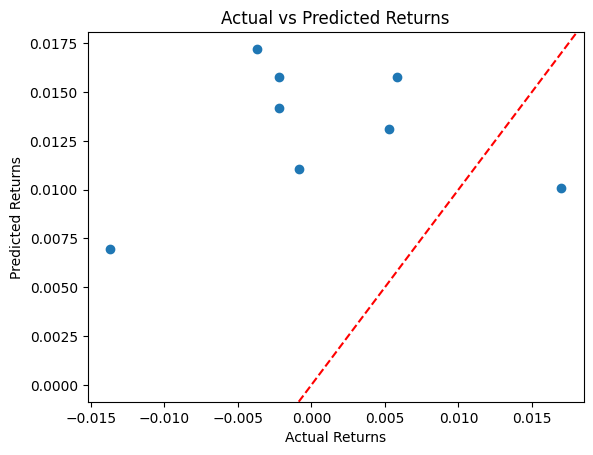

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, preds)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted Returns")
plt.axline((0, 0), slope=1, color='red', linestyle='--')  # Perfect fit line
plt.show()
